# About.
- **Purpose**: This post explains common steps for most typical ML projects.
- **Example**:
  - Kaggle, Predict Podcast Listening Time.
  - https://www.kaggle.com/competitions/playground-series-s5e4/overview
- **History**: 
  - 2025.04.12.
    - 1st trial with the basic preprocessing and the default `LGBMRegressor`.
    - 13.0921 ± 0.0422 (768/1,448; offline)
- **Links**:
  - **GitHub**:
  - **Blog**:

# 0. Setup.

In [1]:
# Install dependencies.
%pip install -r requirements.txt -q

# Imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants.
seed = 42

# Verbose.
verbose = True
vprint = print if verbose else lambda *args, **kwargs: None

Note: you may need to restart the kernel to use updated packages.


# 1. Data Preparation.

## 1.1. Load.

In [2]:
# Load.
df_raw = {}
df_raw['train']  = pd.read_csv('data/podcast/train.csv')    # (x, y_true). For training.
df_raw['final']  = pd.read_csv('data/podcast/test.csv')     # (x, y_pred). We should predict `y_pred` and submit it.

df_raw['train'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


## 1.2. Train-Test Split.

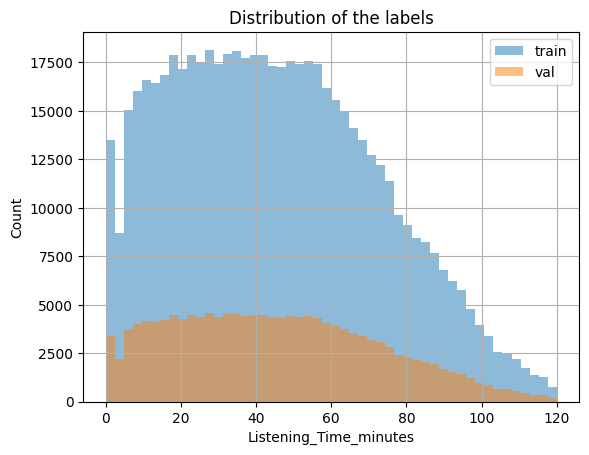

In [3]:
from sklearn.model_selection import train_test_split

label_name = 'Listening_Time_minutes'
df_raw['train'], df_raw['test'] = train_test_split(df_raw['train'], 
                                           test_size     = 0.2, 
                                           random_state  = seed, 
                                           stratify      = df_raw['train'][label_name])

# Sort and reset the index.
df_raw['train'] = df_raw['train'].sort_values(by=['id']).reset_index(drop=True)
df_raw['test']  = df_raw['test'].sort_values(by=['id']).reset_index(drop=True)

# Check the distribution of the labels.
df_raw['train'][label_name].hist(bins=50, alpha=0.5, label='train')
df_raw['test'][label_name].hist(bins=50, alpha=0.5, label='val')

plt.legend()
plt.xlabel(label_name)
plt.ylabel('Count')
plt.title('Distribution of the labels')
plt.show()

In [4]:
# Now we never see the test set, i.e. df_raw['test'], until we finalize the model.
df = df_raw['train'].copy()

display(df.head())

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


# 2. Preprocessing.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           600000 non-null  int64  
 1   Podcast_Name                 600000 non-null  object 
 2   Episode_Title                600000 non-null  object 
 3   Episode_Length_minutes       530219 non-null  float64
 4   Genre                        600000 non-null  object 
 5   Host_Popularity_percentage   600000 non-null  float64
 6   Publication_Day              600000 non-null  object 
 7   Publication_Time             600000 non-null  object 
 8   Guest_Popularity_percentage  483260 non-null  float64
 9   Number_of_Ads                599999 non-null  float64
 10  Episode_Sentiment            600000 non-null  object 
 11  Listening_Time_minutes       600000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 54.9+ MB


## 2.1. Encoding.

In [6]:
cols_cat = df.select_dtypes(include=['object']).columns

for col in cols_cat:
    print(len(df[col].value_counts()))
    display(df[col].value_counts().head(3))

48


Podcast_Name
Tech Talks       18234
Sports Weekly    16063
Funny Folks      15794
Name: count, dtype: int64

100


Episode_Title
Episode 71    8444
Episode 62    8325
Episode 31    8251
Name: count, dtype: int64

10


Genre
Sports        70059
Technology    68952
True Crime    68072
Name: count, dtype: int64

7


Publication_Day
Sunday    92787
Monday    89500
Friday    86544
Name: count, dtype: int64

4


Publication_Time
Night        157450
Evening      156598
Afternoon    143664
Name: count, dtype: int64

3


Episode_Sentiment
Neutral     201125
Negative    200174
Positive    198701
Name: count, dtype: int64

In [7]:
from category_encoders import TargetEncoder

enc_target = TargetEncoder(cols=cols_cat)
df_prep = enc_target.fit_transform(df.drop(columns=[label_name]), df[label_name])
df_prep[label_name] = df[label_name]

df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           600000 non-null  int64  
 1   Podcast_Name                 600000 non-null  float64
 2   Episode_Title                600000 non-null  float64
 3   Episode_Length_minutes       530219 non-null  float64
 4   Genre                        600000 non-null  float64
 5   Host_Popularity_percentage   600000 non-null  float64
 6   Publication_Day              600000 non-null  float64
 7   Publication_Time             600000 non-null  float64
 8   Guest_Popularity_percentage  483260 non-null  float64
 9   Number_of_Ads                599999 non-null  float64
 10  Episode_Sentiment            600000 non-null  float64
 11  Listening_Time_minutes       600000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 54.9 MB


## 2.2. Null Handling.

In [8]:
# Find columns.
cols_null = df_prep.columns[df_prep.isnull().sum() != 0]

# Check values.
for col_null in cols_null:
    idx_null = df_prep[col_null].isnull()

    vprint(f'Column: {col_null}')
    vprint(f'Number of null values: {df_prep[col_null].isnull().sum()}')
    vprint(df_prep[col_null][idx_null].unique(), '\n')

Column: Episode_Length_minutes
Number of null values: 69781
[nan] 

Column: Guest_Popularity_percentage
Number of null values: 116740
[nan] 

Column: Number_of_Ads
Number of null values: 1
[nan] 



In [9]:
# Check the correlation.
cols_corr = list(cols_null) + ['Listening_Time_minutes', 'Host_Popularity_percentage']
display(df_prep.corr()[cols_null])

,Episode_Length_minutes,Guest_Popularity_percentage,Number_of_Ads
id,-0.000909,0.000688,-0.000293
Podcast_Name,0.047517,-0.005066,-0.003854
Episode_Title,0.073692,-0.009543,-0.010546
Episode_Length_minutes,1.000000,-0.010525,-0.053779
Genre,0.018514,-0.011469,-0.002142
Host_Popularity_percentage,0.023114,0.023044,-0.018450
Publication_Day,0.021059,-0.001733,-0.002730
Publication_Time,0.022085,-0.001287,-0.009237
Guest_Popularity_percentage,-0.010525,1.000000,0.008722
Number_of_Ads,-0.053779,0.008722,1.000000


In [10]:
# Seems like we need further analysis and come back later.
# For now, impute everything with the mean.
df_mean = df_prep[cols_null].mean()
df_prep[cols_null] = df_prep[cols_null].fillna(df_mean)

df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           600000 non-null  int64  
 1   Podcast_Name                 600000 non-null  float64
 2   Episode_Title                600000 non-null  float64
 3   Episode_Length_minutes       600000 non-null  float64
 4   Genre                        600000 non-null  float64
 5   Host_Popularity_percentage   600000 non-null  float64
 6   Publication_Day              600000 non-null  float64
 7   Publication_Time             600000 non-null  float64
 8   Guest_Popularity_percentage  600000 non-null  float64
 9   Number_of_Ads                600000 non-null  float64
 10  Episode_Sentiment            600000 non-null  float64
 11  Listening_Time_minutes       600000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 54.9 MB


## 2.3. Feature Engineering.

In [11]:
df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


### 2.3.1. Feature Importance.

#### `LGBMRegressor().feature_importances_`.

In [12]:
from lightgbm import LGBMRegressor

model_feature = LGBMRegressor(random_state=seed, verbose=-1)

x = df_prep.drop(columns=[label_name])
y = df_prep[label_name]

model_feature.fit(x, y)

df_imp = pd.DataFrame({
    'Feature': x.columns,
    'Importance': model_feature.feature_importances_
}).sort_values(by='Importance', ascending=False)

display(df_imp)

,Feature,Importance
3,Episode_Length_minutes,828
5,Host_Popularity_percentage,537
8,Guest_Popularity_percentage,404
2,Episode_Title,273
9,Number_of_Ads,262
1,Podcast_Name,190
6,Publication_Day,118
0,id,115
10,Episode_Sentiment,102
4,Genre,100


#### `permutation_importance`.

In [13]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model_feature, x, y, n_repeats=3, random_state=seed, n_jobs=-1)
importances = result.importances_mean

for i in importances.argsort()[::-1]:
    print(f"{x.columns[i]:<30}: {importances[i]:.4f}")


Episode_Length_minutes        : 1.4832
Number_of_Ads                 : 0.0169
Host_Popularity_percentage    : 0.0074
Guest_Popularity_percentage   : 0.0026
Episode_Title                 : 0.0024
Episode_Sentiment             : 0.0015
Podcast_Name                  : 0.0014
Publication_Day               : 0.0008
Genre                         : 0.0007
Publication_Time              : 0.0005
id                            : 0.0004


#### `shap`.

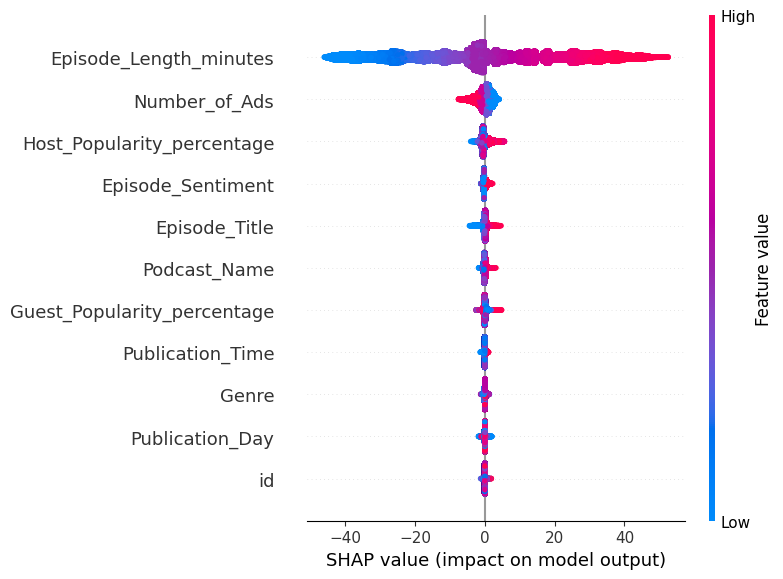

In [14]:
import shap

n_samples = 100_000
x_samples = x.sample(n_samples, random_state=seed)

explainer = shap.TreeExplainer(model_feature, approximate=True, model_output='raw')
shap_values = explainer.shap_values(x)

shap.summary_plot(shap_values, x)


#### Q) Does encoding method affect feature importances unintentionally??

In [15]:
from sklearn.preprocessing import OrdinalEncoder

enc_ord = OrdinalEncoder()
x_enc   = enc_ord.fit_transform(df.drop(columns=[label_name]))
df_ord  = pd.DataFrame(x_enc, columns=df.drop(columns=[label_name]).columns)

df_ord[label_name] = df[label_name].values


model_feature_ord = LGBMRegressor(random_state=seed, verbose=-1)

x = df_prep.drop(columns=[label_name])
y = df_prep[label_name]
model_feature_ord.fit(x, y)

df_imp_ord = pd.DataFrame({
    'Feature': x.columns,
    'Importance': model_feature.feature_importances_
}).sort_values(by='Importance', ascending=False)

display(df_imp_ord)
display(df_imp)

,Feature,Importance
3,Episode_Length_minutes,828
5,Host_Popularity_percentage,537
8,Guest_Popularity_percentage,404
2,Episode_Title,273
9,Number_of_Ads,262
1,Podcast_Name,190
6,Publication_Day,118
0,id,115
10,Episode_Sentiment,102
4,Genre,100


,Feature,Importance
3,Episode_Length_minutes,828
5,Host_Popularity_percentage,537
8,Guest_Popularity_percentage,404
2,Episode_Title,273
9,Number_of_Ads,262
1,Podcast_Name,190
6,Publication_Day,118
0,id,115
10,Episode_Sentiment,102
4,Genre,100


### 2.3.2. Feature Selection.

Let's just keep them all for now.

In [16]:
df.drop(columns=['id'])

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
599995,Style Guide,Episode 83,23.52,Lifestyle,38.14,Tuesday,Evening,86.17,0.0,Neutral,19.71374
599996,Laugh Line,Episode 67,8.93,Comedy,85.52,Saturday,Evening,NaN,1.0,Neutral,7.39878
599997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
599998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


### 2.3.3. Scaling.

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(x)

X_scaled_df = pd.DataFrame(X_scaled, columns=x.columns)
X_scaled_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,0.000000,0.642401,0.072675,0.533636,0.715757,0.624926,0.023213,1.000000,0.435887,0.000000,1.000000
1,0.000001,0.125524,0.526915,0.990656,0.019753,0.558106,0.381466,0.454453,0.633392,0.019247,0.000000
2,0.000003,0.801049,0.392255,0.611097,0.592528,0.583780,1.000000,0.000000,0.074806,0.000000,0.000000
3,0.000004,0.445859,0.920136,0.555445,0.529728,0.475389,0.850906,0.121667,0.656326,0.019247,1.000000
4,0.000005,0.766036,0.406495,0.913834,0.585825,0.669642,0.850906,0.454453,0.489367,0.028871,0.516722


## 2.4. Pipeline for Preprocessing.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

# Prepare the data.
x = df.drop(columns=[label_name])
y = df[label_name]
cols = x.drop(columns=['id']).columns

# Find the categorical columns.
cols_cat = df.select_dtypes(include=['object']).columns.tolist()

# Transformer to drop the 'id' column.
drop_id_transformer = FunctionTransformer(lambda x: x.drop(columns=['id']), validate=False)

# Pipeline.
pipe_prep = Pipeline([
    ('drop_id', drop_id_transformer),                   # 1. Drop 'id'.
    ('target_encode', TargetEncoder(cols=cols_cat)),    # 2. Target encoding for `cols_cat`. Note) TargetEncoder will use 'y' while fitting!
    ('impute', SimpleImputer(strategy='mean')),         # 3. Impute missing values with mean.
    ('scaler', MinMaxScaler())                          # 4. Min-max scaling.
])

# 3. Model.

In [19]:
model_lgbm = LGBMRegressor(random_state=42)

# Pipeline for the model.
pipe_full = Pipeline([
    ('preprocessing', pipe_prep),
    ('model', model_lgbm)
])

# 4. Evaluation.

In [20]:
# Perform cross-validation.
from sklearn.model_selection import cross_val_score, KFold
cv = KFold(n_splits=10, shuffle=True, random_state=seed)

scores = cross_val_score(pipe_full, x, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)

print(f"Average RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

Average RMSE: 13.0921 ± 0.0422


# 5. Deploy.